In [1]:
#---------------------#
### IMPORT PACKAGES ###
#---------------------#
import sys
!conda install --yes --prefix {sys.prefix} category_encoders

import tarfile
import pandas as pd
import pyarrow.parquet as pq
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from category_encoders import TargetEncoder
from category_encoders import BinaryEncoder
from category_encoders import WOEEncoder
from category_encoders import LeaveOneOutEncoder

#------------------------------#
### DATA PROCESSING PIPELINE ###
#------------------------------#
def read_data(data_file):
    pd.set_option('display.max_columns', None)
    tar = tarfile.open(data_file)
    tar.next()
    tn = tar.next()
    tn1 = tar.next()
    tn2 = tar.next()
    tn3 = tar.next()
    tn4 = tar.next()
    tn5 = tar.next()
    tn6 = tar.next()
    tn7 = tar.next()
    tn8 = tar.next()

    df = pd.read_parquet("bigd/M148/" + tn.name)
    df1 = pd.read_parquet("bigd/M148/" +tn1.name)
    df2 = pd.read_parquet("bigd/M148/" +tn2.name)
    df3 = pd.read_parquet("bigd/M148/" +tn3.name)
    df4 = pd.read_parquet("bigd/M148/" +tn4.name)
    df5 = pd.read_parquet("bigd/M148/" +tn5.name)
    df6 = pd.read_parquet("bigd/M148/" +tn6.name)
    df7 = pd.read_parquet("bigd/M148/" +tn7.name)
    df8 = pd.read_parquet("bigd/M148/" +tn8.name)

    df = pd.concat([df, df1, df2, df3, df4, df5, df6, df7, df8])
    print('Converted ' + str(data_file))

    return df

def see_values(data, category):
    counts = pd.DataFrame(data.groupby([category])[category].count())
    counts.rename(columns={category: 'counts'}, inplace=True,)
    counts = counts.sort_values(['counts'], ascending=[0])
    graph = counts.reset_index()
    return graph

def feature_importance(df):
    ### 1st subset: first click ###
    ids_purchase = (df[df['checkoutthankyouflag'] == 1])['visitid'].drop_duplicates()
    ids_purchase = ids_purchase.tolist()
    df_first_visit = df[df['hit_time_gmt']==df['visitstarttimegmt']]
    df_first_visit = df_first_visit.sort_values(by='hit_time_gmt', inplace = False)
    df_first_visit = df_first_visit.drop_duplicates(subset=['visitid'], keep = "first", inplace = False)

    target = list()
    for ids in df_first_visit['visitid']:
        if ids in ids_purchase:
            target.append("1")
        else:
            target.append("0")
            
    df_first_visit.insert(0, "target", target)
    df_first_visit['post_evar23'].head().to_list()
    purchase_percent = pd.DataFrame()
    df_first_visit_purchases = df_first_visit[df_first_visit['visitid'].isin(ids_purchase)]

    for names in df_first_visit_purchases.columns:
        purchase_percent[names] = [100 * (sum(see_values(df_first_visit_purchases, names)['counts'])) / len(df_first_visit_purchases)]
    
    print('Finished 1st subset')

    ### 2nd subset: remove extraneous features ###
    features = list()

    for names in purchase_percent.columns:
        if (purchase_percent[names][0]) > 5:
            features.append(names)

    df_first_subset = df_first_visit[features]

    removed = ['hitdatahistorymkey', 'filename', 'linenumber', 'visitoridhigh', 'visitoridlow', 'hit_time_gmt',
               'visitdatetime', 'postttimeinfo', 'visitdate', 'visitmonth', 'visitid', 'fiscalyear', 'fiscalweeknumber', 
               'fiscalmonthnumber', 'visitstarttimegmt', 'checkoutthankyouflag', 'cookieid', 'lasthittimegmt', 'firsthittimegmt', 
               'lastpurchasetimegmt', 'updatedloaddate', 'initialloaddate']#, 'geocity', 'geocountry', 'georegion']
               #'ip', 'post_evar23', 'prop34', 'zip', 'evar23'] # removed last 7 geographic and user-specific variables

    for variables in df_first_subset.columns:
        if variables in removed:
            features.remove(variables)

    df_second_subset = df_first_subset[features]
    
    numeric = ['visitnumber', 'postbrowserheight', 'postbrowserwidth', 'lastpurchasenum', 'addonsymal', 'cdedspomodel',
               'myaccountengagement', 'post_evar46', 'evar83', 'post_evar30']
    
    for names in df_second_subset.columns:
        if names in numeric:
            df_second_subset[names] = pd.to_numeric(df_second_subset[names]).convert_dtypes()
    
    for names in df_second_subset.columns:
        if ((pd.api.types.is_numeric_dtype(df_second_subset[names]))) != True:
            df_second_subset[names] = df_second_subset[names].fillna("None")

    print('Finished 2nd subset')

    ### 3rd subset: variance threshold ###
    ord_enc = OrdinalEncoder()
    variance_train_categorical = df_second_subset.loc[:, ~df_second_subset.columns.isin(numeric)]
    variance_transformed_categorical = ord_enc.fit_transform(variance_train_categorical)

    var_thr = VarianceThreshold(threshold = 0.01) 
    var_thr.fit(variance_transformed_categorical)

    temp_features = (variance_train_categorical.loc[:,var_thr.get_support()]).columns.to_list()
    df_third_subset = df_second_subset[temp_features]
    df_third_subset = df_third_subset.join(df_second_subset[numeric])

    processed_df = df_third_subset

    features = df_third_subset.columns.to_list()

    print('Finished 3rd subset')

    ### 4th subset: random forest ###
    clf = RandomForestClassifier(class_weight='balanced')

    x_train, x_test, y_train, y_test = train_test_split(df_third_subset.iloc[:,:], 
                                                        df_third_subset['target'], 
                                                        test_size=0.10)

    x_train_1 = x_train[x_train['target'] == "1"]
    y_train_1 = x_train_1['target']
    x_train_2 = x_train[x_train['target'] == "0"].sample(n=len(x_train_1))
    y_train_2 = x_train_2['target']
    x_train = (pd.concat([x_train_1, x_train_2])).iloc[:, 1:]
    y_train = pd.concat([y_train_1, y_train_2])
    x_test = x_test.iloc[:, 1:]

    x_train_categorical = x_train.loc[:, ~x_train.columns.isin(numeric)]
    x_train_numerical = x_train.loc[:, x_train.columns.isin(numeric)]
    x_test_categorical = x_test.loc[:, ~x_test.columns.isin(numeric)]
    x_test_numerical = x_test.loc[:, x_test.columns.isin(numeric)]

    numerical_columns = x_train_numerical.columns.to_list()

    # Ordinal encoding
    ord_enc = OrdinalEncoder()
    y_train_transformed = ord_enc.fit_transform(y_train.to_numpy().reshape(-1,1))
    y_test_transformed = ord_enc.fit_transform(y_test.to_numpy().reshape(-1,1))
    
    # Leave-one-out encoding
    loo_enc = LeaveOneOutEncoder()
    loo_enc.fit(x_train_categorical, y_train_transformed)
    x_train_categorical_transformed = loo_enc.transform(x_train_categorical)
    x_test_categorical_transformed = loo_enc.transform(x_test_categorical)
    
    # Min-max scaling
    minmax = MinMaxScaler()
    x_train_numerical_transformed = minmax.fit_transform(x_train_numerical)
    x_test_numerical_transformed = minmax.transform(x_test_numerical)

    # Create data frames of numerical and categorical variables
    x_train_numerical_transformed = pd.DataFrame(x_train_numerical_transformed, columns = numerical_columns)
    x_train_numerical_transformed = x_train_numerical_transformed.fillna(-999)
    x_test_numerical_transformed = pd.DataFrame(x_test_numerical_transformed)
    x_test_numerical_transformed = x_test_numerical_transformed.fillna(-999)

    x_train_numerical_transformed = x_train_numerical_transformed.astype('float32')
    x_train_categorical_transformed = x_train_categorical_transformed.astype('float32')
    x_test_numerical_transformed = x_test_numerical_transformed.astype('float32')
    x_test_categorical_transformed = x_test_categorical_transformed.astype('float32')

    x_train_total_transformed = np.concatenate([x_train_categorical_transformed.to_numpy(), x_train_numerical_transformed.to_numpy()], axis=1)
    x_test_total_transformed = np.concatenate([x_test_categorical_transformed.to_numpy(), x_test_numerical_transformed.to_numpy()], axis=1)

    # Train the random forest classifier
    clf.fit(x_train_total_transformed, y_train_transformed)
    y_predicted = clf.predict(x_test_total_transformed)
    labels = ['0', '1']

    print('Trained random forest')

    feat_list = []
    total_importance = 0
    for feature in zip(df_third_subset.iloc[:,1:].columns, clf.feature_importances_):
        feat_list.append(feature)
        total_importance += feature[1]

    included_feats = []
    for feature in zip(df_third_subset.iloc[:,1:].columns, clf.feature_importances_):
        if feature[1] > .05:
            included_feats.append(feature[0])

    df_imp = pd.DataFrame(feat_list, columns =['FEATURE', 'IMPORTANCE']).sort_values(by='IMPORTANCE', ascending=False)
    df_imp['CUMSUM'] = df_imp['IMPORTANCE'].cumsum()

    n_features = df_imp.iloc[0:40, 0]

    return processed_df, n_features, target

Solving environment: done

# All requested packages already installed.



In [2]:
!conda install --yes --prefix {sys.prefix} keras

Solving environment: done

# All requested packages already installed.



In [3]:
# Read in, transform data + get list of important features
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# scikit-learn, encoders
import sklearn
from sklearn.utils import shuffle
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from category_encoders import TargetEncoder
from category_encoders import BinaryEncoder
from category_encoders import WOEEncoder
from category_encoders import LeaveOneOutEncoder

# Tensorflow + Keras
#from tensorflow import keras
#from keras.models import Sequential
#from keras.layers import Dense, Dropout

#%%
#------------------#
### PROCESS DATA ###
#------------------#
# Read in, transform data + get list of important features
data_files = ['bigd/M148/hitdata7days_0.tar', 'bigd/M148/hitdata7days_1.tar',
              'bigd/M148/hitdata7days_2.tar', 'bigd/M148/hitdata7days_3.tar', 
              'bigd/M148/hitdata7days_4.tar', 'bigd/M148/hitdata7days_5.tar', 
              'bigd/M148/hitdata7days_6.tar']


df_0 = read_data(data_files[0])
df0_subset, imp_features, target_0 = feature_importance(df_0)

df_1 = read_data(data_files[1])
df1_subset, dummy_vars, target_1 = feature_importance(df_1)

df_2 = read_data(data_files[2])
df2_subset, dummy_vars, target_2 = feature_importance(df_2)

df_3 = read_data(data_files[3])
df3_subset, dummy_vars, target_3 = feature_importance(df_3)

df_4 = read_data(data_files[4])
df4_subset, dummy_vars, target_4 = feature_importance(df_4)

df_5 = read_data(data_files[5])
df5_subset, dummy_vars, target_5 = feature_importance(df_5)

df_6 = read_data(data_files[6])
df6_subset, dummy_vars, target_6 = feature_importance(df_6)

#%%
print(imp_features) # Can take anywhere from 20-40 features

#%%
df_0_full = pd.concat([df0_subset['target'], df0_subset[imp_features]], axis=1)
df_1_full = pd.concat([df1_subset['target'], df1_subset[imp_features]], axis=1)
df_2_full = pd.concat([df2_subset['target'], df2_subset[imp_features]], axis=1)
df_3_full = pd.concat([df3_subset['target'], df3_subset[imp_features]], axis=1)
df_4_full = pd.concat([df4_subset['target'], df4_subset[imp_features]], axis=1)
df_5_full = pd.concat([df5_subset['target'], df5_subset[imp_features]], axis=1)
df_6_full = pd.concat([df6_subset['target'], df6_subset[imp_features]], axis=1)
df_full = pd.concat([df_0_full, df_1_full, df_2_full, df_3_full, df_4_full, df_5_full], axis=0)

#%%
numeric = ['visitnumber', 'postbrowserheight', 'postbrowserwidth', 'lastpurchasenum', 
           'addonsymal', 'resolution', 'cdedspomodel', 'myaccountengagement', 'post_evar46', 
           'evar83', 'post_evar30', 'eventlistlength', 'prodlistlength']

#%%
# Encode data and split into train + test sets
x_train_full = df_full.iloc[:, 1:]
y_train_full = df_full['target']
x_test_full = df_6_full.iloc[:, 1:]
y_test_full = df_6_full['target']

x_train_full['eventlistlength'] = x_train_full.eventlist.str.count(',')
x_test_full['eventlistlength'] = x_test_full.eventlist.str.count(',')
#x_train_full['prodlistlength'] = x_train_full.productlist.str.count(',')
#x_test_full['prodlistlength'] = x_test_full.productlist.str.count(',')

x_train_full = x_train_full.drop(columns=['eventlist'])
x_test_full = x_test_full.drop(columns=['eventlist'])
#x_train_full = x_train_full.drop(columns=['productlist'])
#x_test_full = x_test_full.drop(columns=['productlist'])

#%%
x_train_categorical = x_train_full.loc[:, ~x_train_full.columns.isin(numeric)]
x_test_categorical = x_test_full.loc[:, ~x_test_full.columns.isin(numeric)]

x_train_numerical = x_train_full.loc[:, x_train_full.columns.isin(numeric)]
x_test_numerical = x_test_full.loc[:, x_test_full.columns.isin(numeric)]

numerical_columns = list(x_train_numerical.columns)

#%%
# Ordinal encoding
ord_enc = OrdinalEncoder()
y_train = ord_enc.fit_transform(y_train_full.to_numpy().reshape(-1,1))
y_test = ord_enc.fit_transform(y_test_full.to_numpy().reshape(-1,1))

# Leave-one-out encoding
loo_enc = LeaveOneOutEncoder()
loo_enc.fit(x_train_categorical, y_train)
x_train_categorical_transformed = loo_enc.transform(x_train_categorical)
x_test_categorical_transformed = loo_enc.transform(x_test_categorical)

x_train_categorical_transformed = x_train_categorical_transformed.reset_index(drop=True)
x_test_categorical_transformed = x_test_categorical_transformed.reset_index(drop=True)

# Min-Max normalization
minmax = MinMaxScaler()
x_train_numerical_transformed = minmax.fit_transform(x_train_numerical)
x_test_numerical_transformed = minmax.transform(x_test_numerical)

#%%
# Create data frames and reset indices
x_train_numerical_transformed = pd.DataFrame(x_train_numerical_transformed, columns = [numerical_columns])
x_train_numerical_transformed = x_train_numerical_transformed.fillna(-999)
x_test_numerical_transformed = pd.DataFrame(x_test_numerical_transformed, columns = [numerical_columns])
x_test_numerical_transformed = x_test_numerical_transformed.fillna(-999)

y_train = (pd.DataFrame(y_train, columns=['target'])).reset_index(drop=True)
y_test = (pd.DataFrame(y_test, columns=['target'])).reset_index(drop=True)

x_full_train = pd.concat([y_train, x_train_categorical_transformed, x_train_numerical_transformed], axis=1)
x_full_test = pd.concat([y_test, x_test_categorical_transformed, x_test_numerical_transformed], axis=1)

#%%
# Undersample to construct training set
x_train_1 = x_full_train[x_full_train['target'] == 1]
y_train_1 = x_train_1['target']
x_train_2 = x_full_train[x_full_train['target'] == 0].sample(n=len(y_train_1))
y_train_2 = x_train_2['target']
x_train = (pd.concat([x_train_1, x_train_2])).iloc[:, 1:]
y_train = pd.concat([y_train_1, y_train_2])

x_test_1 = x_full_test[x_full_test['target'] == 1]
y_test_1 = x_test_1['target']
x_test_2 = x_full_test[x_full_test['target'] == 0]#.sample(n=len(y_test_1))
y_test_2 = x_test_2['target']
x_test = (pd.concat([x_test_1, x_test_2])).iloc[:, 1:]
y_test = pd.concat([y_test_1, y_test_2])

x_train, y_train = shuffle(x_train, y_train)

x_train

Converted bigd/M148/hitdata7days_0.tar


/tmp/ipykernel_7537/220212970.py:85: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  purchase_percent[names] = [100 * (sum(see_values(df_first_visit_purchases, names)['counts'])) / len(df_first_visit_purchases)]
/tmp/ipykernel_7537/220212970.py:85: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  purchase_percent[names] = [100 * (sum(see_values(df_first_visit_purchases, names)['counts'])) / len(df_first_visit_purchases)]
/tmp/ipykernel_7537/220212970.py:85: PerformanceWarning: DataFrame is highly fragmented.  This is usually the resu

Finished 1st subset


/tmp/ipykernel_7537/220212970.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_second_subset[names] = pd.to_numeric(df_second_subset[names]).convert_dtypes()
/tmp/ipykernel_7537/220212970.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_second_subset[names] = df_second_subset[names].fillna("None")


Finished 2nd subset
Finished 3rd subset


/tmp/ipykernel_7537/220212970.py:194: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train_total_transformed, y_train_transformed)


Trained random forest
Converted bigd/M148/hitdata7days_1.tar


/tmp/ipykernel_7537/220212970.py:85: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  purchase_percent[names] = [100 * (sum(see_values(df_first_visit_purchases, names)['counts'])) / len(df_first_visit_purchases)]
/tmp/ipykernel_7537/220212970.py:85: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  purchase_percent[names] = [100 * (sum(see_values(df_first_visit_purchases, names)['counts'])) / len(df_first_visit_purchases)]
/tmp/ipykernel_7537/220212970.py:85: PerformanceWarning: DataFrame is highly fragmented.  This is usually the resu

Finished 1st subset


/tmp/ipykernel_7537/220212970.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_second_subset[names] = pd.to_numeric(df_second_subset[names]).convert_dtypes()
/tmp/ipykernel_7537/220212970.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_second_subset[names] = df_second_subset[names].fillna("None")


Finished 2nd subset
Finished 3rd subset


/tmp/ipykernel_7537/220212970.py:194: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train_total_transformed, y_train_transformed)


Trained random forest
Converted bigd/M148/hitdata7days_2.tar


/tmp/ipykernel_7537/220212970.py:85: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  purchase_percent[names] = [100 * (sum(see_values(df_first_visit_purchases, names)['counts'])) / len(df_first_visit_purchases)]
/tmp/ipykernel_7537/220212970.py:85: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  purchase_percent[names] = [100 * (sum(see_values(df_first_visit_purchases, names)['counts'])) / len(df_first_visit_purchases)]
/tmp/ipykernel_7537/220212970.py:85: PerformanceWarning: DataFrame is highly fragmented.  This is usually the resu

Finished 1st subset


/tmp/ipykernel_7537/220212970.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_second_subset[names] = pd.to_numeric(df_second_subset[names]).convert_dtypes()
/tmp/ipykernel_7537/220212970.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_second_subset[names] = df_second_subset[names].fillna("None")


Finished 2nd subset
Finished 3rd subset


/tmp/ipykernel_7537/220212970.py:194: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train_total_transformed, y_train_transformed)


Trained random forest
Converted bigd/M148/hitdata7days_3.tar


/tmp/ipykernel_7537/220212970.py:85: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  purchase_percent[names] = [100 * (sum(see_values(df_first_visit_purchases, names)['counts'])) / len(df_first_visit_purchases)]
/tmp/ipykernel_7537/220212970.py:85: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  purchase_percent[names] = [100 * (sum(see_values(df_first_visit_purchases, names)['counts'])) / len(df_first_visit_purchases)]
/tmp/ipykernel_7537/220212970.py:85: PerformanceWarning: DataFrame is highly fragmented.  This is usually the resu

Finished 1st subset


/tmp/ipykernel_7537/220212970.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_second_subset[names] = pd.to_numeric(df_second_subset[names]).convert_dtypes()
/tmp/ipykernel_7537/220212970.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_second_subset[names] = df_second_subset[names].fillna("None")


Finished 2nd subset
Finished 3rd subset


/tmp/ipykernel_7537/220212970.py:194: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train_total_transformed, y_train_transformed)


Trained random forest
Converted bigd/M148/hitdata7days_4.tar


/tmp/ipykernel_7537/220212970.py:85: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  purchase_percent[names] = [100 * (sum(see_values(df_first_visit_purchases, names)['counts'])) / len(df_first_visit_purchases)]
/tmp/ipykernel_7537/220212970.py:85: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  purchase_percent[names] = [100 * (sum(see_values(df_first_visit_purchases, names)['counts'])) / len(df_first_visit_purchases)]
/tmp/ipykernel_7537/220212970.py:85: PerformanceWarning: DataFrame is highly fragmented.  This is usually the resu

Finished 1st subset


/tmp/ipykernel_7537/220212970.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_second_subset[names] = pd.to_numeric(df_second_subset[names]).convert_dtypes()
/tmp/ipykernel_7537/220212970.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_second_subset[names] = df_second_subset[names].fillna("None")


Finished 2nd subset
Finished 3rd subset


/tmp/ipykernel_7537/220212970.py:194: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train_total_transformed, y_train_transformed)


Trained random forest
Converted bigd/M148/hitdata7days_5.tar


/tmp/ipykernel_7537/220212970.py:85: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  purchase_percent[names] = [100 * (sum(see_values(df_first_visit_purchases, names)['counts'])) / len(df_first_visit_purchases)]
/tmp/ipykernel_7537/220212970.py:85: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  purchase_percent[names] = [100 * (sum(see_values(df_first_visit_purchases, names)['counts'])) / len(df_first_visit_purchases)]
/tmp/ipykernel_7537/220212970.py:85: PerformanceWarning: DataFrame is highly fragmented.  This is usually the resu

Finished 1st subset


/tmp/ipykernel_7537/220212970.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_second_subset[names] = pd.to_numeric(df_second_subset[names]).convert_dtypes()
/tmp/ipykernel_7537/220212970.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_second_subset[names] = df_second_subset[names].fillna("None")


Finished 2nd subset
Finished 3rd subset


/tmp/ipykernel_7537/220212970.py:194: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train_total_transformed, y_train_transformed)


Trained random forest
Converted bigd/M148/hitdata7days_6.tar


/tmp/ipykernel_7537/220212970.py:85: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  purchase_percent[names] = [100 * (sum(see_values(df_first_visit_purchases, names)['counts'])) / len(df_first_visit_purchases)]
/tmp/ipykernel_7537/220212970.py:85: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  purchase_percent[names] = [100 * (sum(see_values(df_first_visit_purchases, names)['counts'])) / len(df_first_visit_purchases)]
/tmp/ipykernel_7537/220212970.py:85: PerformanceWarning: DataFrame is highly fragmented.  This is usually the resu

Finished 1st subset


/tmp/ipykernel_7537/220212970.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_second_subset[names] = pd.to_numeric(df_second_subset[names]).convert_dtypes()
/tmp/ipykernel_7537/220212970.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_second_subset[names] = df_second_subset[names].fillna("None")


Finished 2nd subset
Finished 3rd subset


/tmp/ipykernel_7537/220212970.py:194: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train_total_transformed, y_train_transformed)


Trained random forest
39                     geocity
70                 post_evar23
3                           ip
19                      prop34
68                 post_evar13
2                    eventlist
71                 post_evar24
75                 post_evar33
52                      evar23
23                   useragent
51            crosssoldproduct
53                      evar24
100                visitnumber
30                      domain
17                      prop29
60               institutionid
101          postbrowserheight
41                   georegion
74                 post_evar28
24                         zip
108                     evar83
79                 post_evar43
106        myaccountengagement
6                      pageurl
109                post_evar30
102           postbrowserwidth
32                          os
11                 subcategory
33                  resolution
104                 addonsymal
10                    category
7                

,geocity,post_evar23,ip,prop34,post_evar13,post_evar24,post_evar33,evar23,useragent,crosssoldproduct,evar24,domain,prop29,institutionid,georegion,post_evar28,zip,post_evar43,pageurl,os,subcategory,category,pagename,browser,post_evar12,subcategory2,prop44,visitstartpagename,evar56,firsthitpagename,emailsubscriptionremove,"(visitnumber,)","(postbrowserheight,)","(evar83,)","(myaccountengagement,)","(post_evar30,)","(postbrowserwidth,)","(resolution,)","(addonsymal,)","(eventlistlength,)"
2233,0.057534,0.142857,0.250000,0.200000,0.142857,0.119497,0.078508,0.142857,0.061040,0.142857,0.118959,0.048454,0.076744,0.085615,0.049723,0.073850,0.055556,0.084020,0.054316,0.049901,0.051813,0.051813,0.054307,0.046662,0.054045,0.051813,0.088558,0.053440,0.052800,0.061154,0.052811,0.000571,0.014212,0.549618,0.403846,0.024033,0.080859,0.238153,0.024033,0.66
303911,0.040872,0.005403,0.000000,0.047767,0.012578,0.024983,0.007997,0.018122,0.072839,0.016872,0.029913,0.000000,0.016860,0.006762,0.046200,0.020006,0.028948,0.007078,0.045281,0.071328,0.046373,0.046373,0.044102,0.072910,0.046372,0.046373,0.018681,0.053755,0.046016,0.047663,0.046835,0.000000,0.019390,-999.000000,0.375000,-999.000000,0.311328,0.226002,-999.000000,0.34
269418,0.054598,0.047767,0.047767,0.047767,0.047767,0.059072,0.078508,0.047767,0.052143,0.047767,0.029913,0.054380,0.095837,0.052620,0.049723,0.092622,0.028948,0.084020,0.054316,0.047130,0.053711,0.053711,0.054307,0.046662,0.054045,0.053711,0.088558,0.053440,0.052800,0.047663,0.052811,0.009714,0.014830,0.790076,-999.000000,0.017479,0.073242,0.000000,0.017479,0.46
382221,0.034821,0.666667,0.500000,0.666667,0.666667,0.145455,0.078508,0.666667,0.086729,0.666667,0.135135,0.053725,0.095837,0.085615,0.048001,0.092622,0.200000,0.084020,1.000000,0.085359,0.046373,0.046373,0.044102,0.072910,1.000000,0.046373,0.088558,0.047123,0.046016,0.047663,0.084668,0.007714,0.014851,0.793893,0.730769,0.002341,0.266797,0.224787,0.002341,0.88
116204,0.045498,0.000000,0.047767,0.042024,0.012578,0.024983,0.078508,0.018122,0.042698,0.016872,0.029913,0.039413,0.016860,0.052620,0.053640,0.020006,0.028948,0.054104,0.045281,0.044324,0.053711,0.053711,0.044102,0.045567,0.038339,0.053711,0.018681,0.053755,0.042156,0.053249,0.042158,0.000571,0.015704,-999.000000,-999.000000,-999.000000,0.083594,0.329283,-999.000000,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210886,0.041374,0.000000,0.000000,0.000000,0.000000,0.061709,0.078508,0.000000,0.000000,0.000000,0.061793,0.052146,0.057626,0.085615,0.046722,0.070493,0.125000,0.084020,0.047767,0.045550,0.000000,0.010616,0.000000,0.029762,0.047767,0.000000,0.088558,0.000000,0.000000,0.053249,0.000000,0.019714,0.013786,0.492366,0.509615,0.022472,0.070312,0.314702,0.022472,0.92
266959,0.050891,0.142857,0.166667,0.200000,0.142857,0.091398,0.078508,0.142857,0.078675,0.142857,0.086185,0.052330,0.076744,0.085615,0.049723,0.020006,0.055556,0.084020,0.116067,0.038548,0.104038,0.104038,0.114898,0.071653,0.119321,0.104038,0.088558,0.101286,0.120946,0.053249,0.121986,0.000857,0.015490,-999.000000,0.557692,-999.000000,0.233203,0.046173,-999.000000,0.64
88276,0.087719,0.000000,0.000000,0.000000,0.012578,0.024983,0.078508,0.000000,0.012987,0.016872,0.029913,0.053156,0.016860,0.052620,0.041131,0.020006,0.028948,0.054104,0.054316,0.047535,0.053711,0.053711,0.054307,0.049685,0.054045,0.053711,0.088558,0.053755,0.052800,0.072809,0.052811,0.000000,0.013956,-999.000000,-999.000000,-999.000000,0.076172,0.000000,-999.000000,0.28
65660,0.041667,0.000000,0.000000,0.000000,0.000000,0.048138,0.078508,0.000000,0.042698,0.000000,0.047966,0.052330,0.061038,0.044603,0.041131,0.020006,0.142857,0.042285,0.047767,0.044324,0.053711,0.053711,0.051633,0.045567,0.047767,0.053711,0.044006,0.046338,0.052822,0.053249,0.047767,0.000286,0.014148,-999.000000,0.394231,-999.000000,0.076172,0.325638,-999.000000,0.52


In [5]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='lbfgs', max_iter=150)

          
model.fit(x_train, y_train)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(


LogisticRegression(max_iter=150)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(


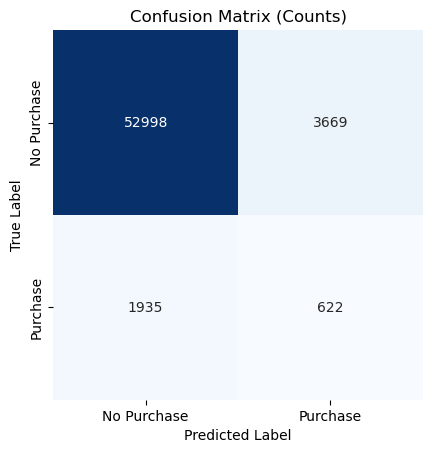

In [17]:
threshold_prob = 0.3 # depends on results
y_predicted = model.predict(x_test) > threshold_prob
mat = confusion_matrix(y_test, y_predicted)
classes = ['No Purchase', 'Purchase']

sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=classes, yticklabels=classes)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Counts)')
plt.show()

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(


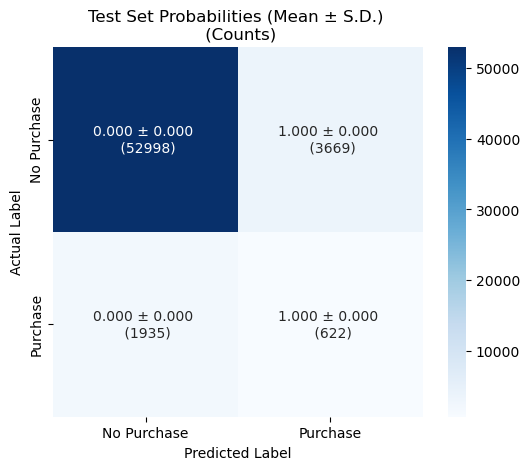

In [42]:
# Analysis of model inference
y_predicted = np.array(model.predict(x_test))

true_0_indices = np.where(y_test == 0)
true_1_indices = np.where(y_test == 1)
predict_0_indices = np.where(y_predicted < threshold_prob)[0]
predict_1_indices = np.where(y_predicted >= threshold_prob)[0]

prob_0_true = y_predicted[np.intersect1d(true_0_indices, predict_0_indices)]
prob_0_false = y_predicted[np.intersect1d(true_0_indices, predict_1_indices)]
prob_1_true = y_predicted[np.intersect1d(true_1_indices, predict_1_indices)]
prob_1_false = y_predicted[np.intersect1d(true_1_indices, predict_0_indices)]


mean_prob = np.array([[np.mean(prob_0_true), np.mean(prob_0_false)], 
                     [np.mean(prob_1_false), np.mean(prob_1_true)]])

sd_prob = np.array([[np.std(prob_0_true), np.std(prob_0_false)], 
                    [np.std(prob_1_false), np.std(prob_1_true)]])

entries = (np.asarray([u"{0:.3f} \u00B1 {1:.3f} \n ({2:.0f})".format(value1, value2, value3)
                      for value1, value2, value3 in zip(mean_prob.flatten(),
                                                        sd_prob.flatten(),
                                                        mat.flatten())])
          ).reshape(2, 2)

sns.heatmap(mat, square=True, annot=entries, fmt='', cbar=True, cmap='Blues',
            xticklabels=classes, yticklabels=classes)

plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title(u'Test Set Probabilities (Mean \u00B1 S.D.) \n (Counts)')
plt.show()


#%%
#------------------------------#
### MODEL TRAINING + RESULTS ###
#------------------------------#
# Hyperparameters
num_epochs = 100 # number of epochs
num_obs = 512 # batch size
adam_opt = keras.optimizers.Adam(learning_rate=0.001, amsgrad=True) # Adam optimizer
sgd_opt = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9) # Stochastic gradient method optimizer

model = Sequential()
model.add(Dense(128, activation='sigmoid', input_dim=40)) # Sigmoid works better than ReLU and Tanh
model.add(Dropout(0.75))
model.add(Dense(128, activation='sigmoid'))
model.add(Dropout(0.75))
model.add(Dense(1, activation='sigmoid')) 
model.compile(loss='binary_crossentropy', optimizer=adam_opt, 
              metrics=['accuracy', keras.metrics.AUC(name='auc')])
model.summary()

#%%
# Train neural network
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=num_epochs, batch_size=num_obs)

#%%
# Plot learning curves
sns.set()
auc_score = hist.history['auc']
val_auc = hist.history['val_auc']
epochs = range(1, len(auc_score) + 1)
plt.plot(epochs, auc_score, '-', label='Training AUC', alpha=1)
plt.plot(epochs, val_auc, '-', label='Validation AUC', alpha=0.75)
plt.title('Training and Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend(loc='lower right')
plt.plot()
plt.show()

acc_score = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
plt.plot(epochs, acc_score, '-', label='Training Accuracy', alpha=1) 
plt.plot(epochs, val_acc, '-', label='Validation Accuracy', alpha=0.75)
plt.title('Training and Validation Accuracy') 
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()
plt.show()

loss = hist.history['loss']
val_loss = hist.history['val_loss']
plt.plot(epochs, loss, '-', label='Training Loss', alpha=1)
plt.plot(epochs, val_loss, '-', label='Validation Loss', alpha=0.75)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

#%%
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(model.predict(x_test) * 100, bins = range(0,100,10))

#%%
# Confusion matrix
threshold_prob = 0.3 # depends on results
y_predicted = model.predict(x_test) > threshold_prob
mat = confusion_matrix(y_test, y_predicted)
classes = ['No Purchase', 'Purchase']

sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=classes, yticklabels=classes)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Counts)')
plt.show()

# Analysis of model inference
y_predicted = np.array(np.concatenate(model.predict(x_test)))
true_0_indices = np.where(y_test == 0)
true_1_indices = np.where(y_test == 1)
predict_0_indices = np.where(y_predicted < threshold_prob)[0]
predict_1_indices = np.where(y_predicted >= threshold_prob)[0]

prob_0_true = y_predicted[np.intersect1d(true_0_indices, predict_0_indices)]
prob_0_false = y_predicted[np.intersect1d(true_0_indices, predict_1_indices)]
prob_1_true = y_predicted[np.intersect1d(true_1_indices, predict_1_indices)]
prob_1_false = y_predicted[np.intersect1d(true_1_indices, predict_0_indices)]

mean_prob = np.array([[np.mean(prob_0_true), np.mean(prob_0_false)], 
                     [np.mean(prob_1_false), np.mean(prob_1_true)]])

sd_prob = np.array([[np.std(prob_0_true), np.std(prob_0_false)], 
                    [np.std(prob_1_false), np.std(prob_1_true)]])

entries = (np.asarray([u"{0:.3f} \u00B1 {1:.3f} \n ({2:.0f})".format(value1, value2, value3)
                      for value1, value2, value3 in zip(mean_prob.flatten(),
                                                        sd_prob.flatten(),
                                                        mat.flatten())])
          ).reshape(2, 2)

sns.heatmap(mat, square=True, annot=entries, fmt='', cbar=True, cmap='Blues',
            xticklabels=classes, yticklabels=classes)

plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title(u'Test Set Probabilities (Mean \u00B1 S.D.) \n (Counts)')
plt.show()
#%%